# IBM - Applied Data Science Capstone Project
## Analysing Melbourne Housing Market
### By Zin Myint Naung

## Table of Contents

1. Introduction
2. Data
3. Methodology  
4. Result & Findings
5. Recommendation
6. Conclusion

# 1. Introduction
Melbourne topped the “Global Liveability Index” list for seven years from 2011 to 2017. Although it was beaten by Vienna in 2018, it still maintains in top three with a score of 98.4 in 2019. Moreover, it achieved scores of 100 in healthcare, education and infrastructure. Melbourne is often considered as Australia’s cultural capital with its thriving arts scene. With city population reaching to almost 5millions in 2019, the demand for owning a house in Melbourne has become a challenge to many new buyers. In this project, we will be analysing Melbourne’s housing market in order to highlight our findings so that it can help both potential buyers and real estate agencies while making their decision. 

### Step 1: Import Libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.options.display.float_format = '{:.2f}'.format

import json # library to handle JSON files

import geocoder as geocoder
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


# 2. Data

### Step 2: Data Preparation

Melbourne’s housing price list can be downloaded from Kaggle’s open datasets. This dataset save our time from scraping suburban data from other third party website such as Wikipedia. The dataset also contains latitude and longitude values for further analysis. The URL for the data is as shown below:
https://www.kaggle.com/anthonypino/melbourne-housing-market#Melbourne_housing_FULL.csv

In [161]:
df = pd.read_csv('Melbourne_housing_FULL.csv')
df.head()

Suburb             Address  Rooms Type      Price Method SellerG  \
0  Abbotsford       68 Studley St      2    h        nan     SS  Jellis   
1  Abbotsford        85 Turner St      2    h 1480000.00      S  Biggin   
2  Abbotsford     25 Bloomburg St      2    h 1035000.00      S  Biggin   
3  Abbotsford  18/659 Victoria St      3    u        nan     VB  Rounds   
4  Abbotsford        5 Charles St      3    h 1465000.00     SP  Biggin   

        Date  Distance  Postcode  Bedroom2  Bathroom  Car  Landsize  \
0  3/09/2016      2.50   3067.00      2.00      1.00 1.00    126.00   
1  3/12/2016      2.50   3067.00      2.00      1.00 1.00    202.00   
2  4/02/2016      2.50   3067.00      2.00      1.00 0.00    156.00   
3  4/02/2016      2.50   3067.00      3.00      2.00 1.00      0.00   
4  4/03/2017      2.50   3067.00      3.00      2.00 0.00    134.00   

   BuildingArea  YearBuilt         CouncilArea  Lattitude  Longtitude  \
0           nan        nan  Yarra City Council     -37.80      145.00   
1           nan        nan  Yarra City Council     -37.80      145.00   
2         79.00    1900.00  Yarra City Council     -37.81      144.99   
3           nan        nan  Yarra City Council     -37.81      145.01   
4        150.00    1900.00  Yarra City Council     -37.81      144.99   

              Regionname  Propertycount  
0  Northern Metropolitan        4019.00  
1  Northern Metropolitan        4019.00  
2  Northern Metropolitan        4019.00  
3  Northern Metropolitan        4019.00  
4  Northern Metropolitan        4019.00

In [3]:
df.shape

(34857, 21)

In [4]:
df = df[['Suburb', 'Price', 'Postcode', 'Lattitude', 'Longtitude']]
df['Neighbourhood'] = df[['Suburb']]
df.head()

Suburb      Price  Postcode  Lattitude  Longtitude Neighbourhood
0  Abbotsford        nan   3067.00     -37.80      145.00    Abbotsford
1  Abbotsford 1480000.00   3067.00     -37.80      145.00    Abbotsford
2  Abbotsford 1035000.00   3067.00     -37.81      144.99    Abbotsford
3  Abbotsford        nan   3067.00     -37.81      145.01    Abbotsford
4  Abbotsford 1465000.00   3067.00     -37.81      144.99    Abbotsford

In [5]:
df = df.dropna()
df.shape

(20993, 6)

### Step 3: Calculating mean (µ) value
We will calculate the mean value for each suburb using pandas groupby() method. Then re-create our data frame using python list as shown below.

In [6]:
df.reset_index(drop=True)
df = pd.DataFrame(df.groupby(['Suburb'], sort = False).mean())
df.head()

Price  Postcode  Lattitude  Longtitude
Suburb                                                  
Abbotsford   1096603.90   3067.00     -37.80      145.00
Airport West  780529.42   3042.00     -37.72      144.88
Albert Park  1983664.71   3206.00     -37.84      144.95
Alphington   1441155.56   3078.00     -37.78      145.03
Altona        872917.93   3018.00     -37.87      144.82

In [8]:
ls = []

for index, row in df.iterrows():
    ls.append((index, row['Postcode'], row['Price'], row['Lattitude'], row['Longtitude']))
data = pd.DataFrame(ls, columns = ('Suburb', 'Postcode', 'AvgPrice', 'Lattitude', 'Longtitude'))
data.head()

Suburb  Postcode   AvgPrice  Lattitude  Longtitude
0    Abbotsford   3067.00 1096603.90     -37.80      145.00
1  Airport West   3042.00  780529.42     -37.72      144.88
2   Albert Park   3206.00 1983664.71     -37.84      144.95
3    Alphington   3078.00 1441155.56     -37.78      145.03
4        Altona   3018.00  872917.93     -37.87      144.82

# 3. Methodology

### Step 4: Visualizing Housing Price of Melbourne
To visualize our data set on the map of Melbourne, we will use Nominatim, a search engine for OpenStreetMap data to fetch the latitude and longitude data of Melbourne city. Then we will use Folium library to draw the map and add our data as markers on the map.

In [9]:
address = 'Melbourne, Victoria'

geolocator = Nominatim(user_agent="melbourne_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Melbourne are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Melbourne are -37.8142176, 144.9631608.


In [10]:
# create map of Melbourne using latitude and longitude values
map_melbourne = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, suburb in zip(data['Lattitude'], data['Longtitude'], data['Suburb']):
    label = '{}, {}'.format(data, suburb)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_melbourne)  
    
map_melbourne

### Step 5: Prepare for Foursquare API

In [11]:
CLIENT_ID = 'TGMPXAQXAHIPIEVB2Q2GKVVNJ34L5KX4Y5IQVQEV5JBLBHUR' # your Foursquare ID
CLIENT_SECRET = 'E3YE5OPQ0BU4HQUWNQSYLJ4EQX0W5HBDYV5XEYKLWAVFEFOR' # your Foursquare Secret
VERSION = '20180604'

In [12]:
def getBuiltUrl(neigh_lat,neigh_long,radius=1400):
    # type your answer here
    LIMIT=100
    #radius=1000
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neigh_lat, 
    neigh_long, 
    radius, 
    LIMIT)
    return url

In [14]:
neigh_name, neigh_post, neigh_price, neigh_lat, neigh_long = data.iloc[0]
print('Latitude and longitude values of {} are {}, {}.'.format(neigh_name, 
                                                               neigh_lat, 
                                                               neigh_long))
results = requests.get(getBuiltUrl(neigh_lat,neigh_long)).json()
results

Latitude and longitude values of Abbotsford are -37.8040351948052, 144.99731766233762.


{'meta': {'code': 200, 'requestId': '5df1cbee1a4b0a001be6dc11'},
 'response': {'groups': [{'items': [{'reasons': {'count': 0,
       'items': [{'reasonName': 'globalInteractionReason',
         'summary': 'This spot is popular',
         'type': 'general'}]},
      'referralId': 'e-0-4b5ccacbf964a520424429e3-0',
      'venue': {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/cafe_',
          'suffix': '.png'},
         'id': '4bf58dd8d48988d16d941735',
         'name': 'Café',
         'pluralName': 'Cafés',
         'primary': True,
         'shortName': 'Café'}],
       'id': '4b5ccacbf964a520424429e3',
       'location': {'address': '60 Nicholson St',
        'cc': 'AU',
        'city': 'Abbotsford',
        'country': 'Australia',
        'distance': 370,
        'formattedAddress': ['60 Nicholson St',
         'Abbotsford VIC 3067',
         'Australia'],
        'labeledLatLngs': [{'label': 'display',
          'lat': -37.8073178966101,
          

In [15]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### Step 6: Fetching Nearby Venues
Housing prices are strongly influenced by its locations. Therefore, it is crucial to examine pricing based on where the property is located. To serve this purpose, we will use Foursquare API to fetch nearby venues of all the suburbs in our data set.

In [16]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

name                     categories    lat  \
0                      Three Bags Full                           Café -37.81   
1                   Lentil As Anything  Vegetarian / Vegan Restaurant -37.80   
2  Stomping Ground Brewery & Beer Hall                        Brewery -37.80   
3                                 Au79                           Café -37.81   
4                          Laird Hotel                        Gay Bar -37.81   

     lng  
0 145.00  
1 145.00  
2 144.99  
3 145.00  
4 144.99

In [163]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


In [18]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        LIMIT=100
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Step 7: Fetch nearby venues for all Suburb

In [20]:
melbourne_venues = getNearbyVenues(names=data['Suburb'], 
                                   latitudes=data['Lattitude'], 
                                   longitudes=data['Longtitude'], 
                                   radius=500)

Abbotsford
Airport West
Albert Park
Alphington
Altona
Altona North
Armadale
Ascot Vale
Ashburton
Ashwood
Avondale Heights
Balaclava
Balwyn
Balwyn North
Bentleigh
Bentleigh East
Box Hill
Braybrook
Brighton
Brighton East
Brunswick
Brunswick West
Bulleen
Burwood
Camberwell
Canterbury
Carlton North
Carnegie
Caulfield
Caulfield North
Caulfield South
Chadstone
Clifton Hill
Coburg
Coburg North
Collingwood
Doncaster
Eaglemont
Elsternwick
Elwood
Essendon
Essendon North
Fairfield
Fitzroy
Fitzroy North
Flemington
Footscray
Glen Iris
Glenroy
Gowanbrae
Hadfield
Hampton
Hampton East
Hawthorn
Heidelberg Heights
Heidelberg West
Hughesdale
Ivanhoe
Kealba
Keilor East
Kensington
Kew
Kew East
Kooyong
Maidstone
Malvern
Malvern East
Maribyrnong
Melbourne
Middle Park
Mont Albert
Moonee Ponds
Moorabbin
Newport
Niddrie
North Melbourne
Northcote
Oak Park
Oakleigh South
Parkville
Pascoe Vale
Port Melbourne
Prahran
Preston
Reservoir
Richmond
Rosanna
Seddon
South Melbourne
South Yarra
Southbank
Spotswood
St Kilda


In [22]:
melbourne_venues.groupby('Neighborhood').count()

Neighborhood Latitude  Neighborhood Longitude  Venue  \
Neighborhood                                                               
Abbotsford                             18                      18     18   
Aberfeldie                              2                       2      2   
Airport West                            3                       3      3   
Albanvale                               1                       1      1   
Albert Park                            30                      30     30   
Albion                                  1                       1      1   
Alphington                              8                       8      8   
Altona                                  1                       1      1   
Altona North                            7                       7      7   
Ardeer                                  1                       1      1   
Armadale                               12                      12     12   
Ascot Vale                             21                      21     21   
Ashburton                              10                      10     10   
Ashwood                                 4                       4      4   
Aspendale                               5                       5      5   
Aspendale Gardens                       4                       4      4   
Attwood                                 4                       4      4   
Avondale Heights                        2                       2      2   
Bacchus Marsh                           1                       1      1   
Balaclava                              47                      47     47   
Balwyn                                 17                      17     17   
Balwyn North                            2                       2      2   
Bayswater                               1                       1      1   
Bayswater North                         6                       6      6   
Beaconsfield Upper                      2                       2      2   
Beaumaris                               3                       3      3   
Bellfield                               4                       4      4   
Bentleigh                               5                       5      5   
Bentleigh East                          1                       1      1   
Black Rock                             21                      21     21   
Blackburn                              15                      15     15   
Blackburn South                         4                       4      4   
Bonbeach                                6                       6      6   
Boronia                                 1                       1      1   
Botanic Ridge                           5                       5      5   
Box Hill                                8                       8      8   
Braybrook                               6                       6      6   
Briar Hill                              5                       5      5   
Brighton                                5                       5      5   
Brighton East                          10                      10     10   
Broadmeadows                            2                       2      2   
Brookfield                              2                       2      2   
Brooklyn                                1                       1      1   
Brunswick                              45                      45     45   
Brunswick East                         33                      33     33   
Brunswick West                         10                      10     10   
Bulla                                   3                       3      3   
Bulleen                                 6                       6      6   
Bundoora                               10                      10     10   
Burnley                                16                      16     16   
Burnside                                2                       2   

In [23]:
print('There are {} uniques categories.'.format(len(melbourne_venues['Venue Category'].unique())))

There are 299 uniques categories.


In [24]:
# one hot encoding
melbourne_onehot = pd.get_dummies(melbourne_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
melbourne_onehot['Neighborhood'] = melbourne_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [melbourne_onehot.columns[-1]] + list(melbourne_onehot.columns[:-1])
london_onehot = melbourne_onehot[fixed_columns]

melbourne_onehot.head()

Accessories Store  Afghan Restaurant  African Restaurant  \
0                  0                  0                   0   
1                  0                  0                   0   
2                  0                  0                   0   
3                  0                  0                   0   
4                  0                  0                   0   

   American Restaurant  Antique Shop  Arcade  Argentinian Restaurant  \
0                    0             0       0                       0   
1                    0             0       0                       0   
2                    0             0       0                       0   
3                    0             0       0                       0   
4                    0             0       0                       0   

   Art Gallery  Arts & Crafts Store  Asian Restaurant  Athletics & Sports  \
0            0                    0                 0                   0   
1            0                    0                 0                   0   
2            0                    0                 0                   0   
3            0                    0                 0                   0   
4            0                    0                 0                   0   

   Australian Restaurant  Austrian Restaurant  Auto Dealership  Auto Workshop  \
0                      0                    0                0              0   
1                      0                    0                0              0   
2                      0                    0                0              0   
3                      0                    0                0              0   
4                      0                    0                0              0   

   Automotive Shop  BBQ Joint  Baby Store  Badminton Court  Bagel Shop  \
0                0          0           0                0           0   
1                0          0           0                0           0   
2                0          0           0                0           0   
3                0          0           0                0           0   
4                0          0           0                0           0   

   Bakery  Bar  Baseball Field  Basketball Court  Basketball Stadium  \
0       0    0               0                 0                   0   
1       0    0               0                 0                   0   
2       0    0               0                 0                   0   
3       0    0               0                 0                   0   
4       0    0               0                 0                   0   

   Bath House  Beach  Bed & Breakfast  Beer Bar  Beer Garden  Beer Store  \
0           0      0                0         0            0           0   
1           0      0                0         0            0           0   
2           0      0                0         0            0           0   
3           0      0                0         0            0           0   
4           0      0                0         0            0           0   

   Big Box Store  Board Shop  Boat or Ferry  Bookstore  Boutique  \
0              0           0              0          0         0   
1              0           0              0          0         0   
2              0           0              0          0         0   
3              0           0              0          0         0   
4              0           0              0          0         0   

   Bowling Alley  Bowling Green  Boxing Gym  Brazilian Restaurant  \
0              0              0           0                     0   
1              0              0           0                     0   
2              0              0           0                     0   
3              0              0           0                     0   
4              0              0           0                     0   

   Breakfast Spot  Brewery  Bridal Shop  Bubble Tea Shop  Buffet  \
0             

In [26]:
melbourne_grouped = melbourne_onehot.groupby('Neighborhood').mean().reset_index()
melbourne_grouped

Neighborhood  Accessories Store  Afghan Restaurant  \
0            Abbotsford               0.00               0.00   
1            Aberfeldie               0.00               0.00   
2          Airport West               0.00               0.00   
3             Albanvale               0.00               0.00   
4           Albert Park               0.00               0.00   
5                Albion               0.00               0.00   
6            Alphington               0.00               0.00   
7                Altona               0.00               0.00   
8          Altona North               0.00               0.00   
9                Ardeer               0.00               0.00   
10             Armadale               0.00               0.00   
11           Ascot Vale               0.00               0.00   
12            Ashburton               0.00               0.10   
13              Ashwood               0.00               0.00   
14            Aspendale               0.00               0.00   
15    Aspendale Gardens               0.00               0.00   
16              Attwood               0.00               0.00   
17     Avondale Heights               0.00               0.00   
18        Bacchus Marsh               0.00               0.00   
19            Balaclava               0.00               0.00   
20               Balwyn               0.00               0.00   
21         Balwyn North               0.00               0.00   
22            Bayswater               0.00               0.00   
23      Bayswater North               0.00               0.00   
24   Beaconsfield Upper               0.00               0.00   
25            Beaumaris               0.00               0.00   
26            Bellfield               0.00               0.00   
27            Bentleigh               0.00               0.00   
28       Bentleigh East               0.00               0.00   
29           Black Rock               0.00               0.00   
30            Blackburn               0.00               0.00   
31      Blackburn South               0.00               0.00   
32             Bonbeach               0.00               0.00   
33              Boronia               0.00               0.00   
34        Botanic Ridge               0.00               0.00   
35             Box Hill               0.00               0.00   
36            Braybrook               0.00               0.00   
37           Briar Hill               0.00               0.00   
38             Brighton               0.00               0.00   
39        Brighton East               0.00               0.00   
40         Broadmeadows               0.00               0.00   
41           Brookfield               0.00               0.00   
42             Brooklyn               0.00               0.00   
43            Brunswick               0.00               0.02   
44       Brunswick East               0.00               0.00   
45       Brunswick West               0.00               0.00   
46                Bulla               0.00               0.00   
47              Bulleen               0.00               0.00   
48             Bundoora               0.00               0.00   
49              Burnley               0.00               0.00   
50             Burnside               0.00               0.00   
51     Burnside Heights               0.00               0.00   
52              Burwood               0.00               0.00   
53         Burwood East               0.00               0.00   
54             Cairnlea               0.00               0.00   
55           Camberwell               0.00               0.00   
56        Campbellfield               0.00               0.00   
57           Canterbury               0.00               0.00   
58              Carlton               0.00               0.00   
59        Carlton North               0.00               0.00   
60             Carnegie               0.00    

### Step 8: List  top 10 venues for each Suburb

In [28]:
a=melbourne_grouped
num_top_venues = 10

for hood in melbourne_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = a[a['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Abbotsford----
                    venue  freq
0                    Café  0.17
1                     Pub  0.17
2                 Gay Bar  0.06
3       Convenience Store  0.06
4             Coffee Shop  0.06
5               Hotel Bar  0.06
6             Pizza Place  0.06
7  Thrift / Vintage Store  0.06
8        Greek Restaurant  0.06
9           Grocery Store  0.06


----Aberfeldie----
                           venue  freq
0                  Grocery Store  0.50
1                           Café  0.50
2           Other Great Outdoors  0.00
3               Pedestrian Plaza  0.00
4                           Park  0.00
5  Paper / Office Supplies Store  0.00
6           Pakistani Restaurant  0.00
7              Paella Restaurant  0.00
8              Other Repair Shop  0.00
9              Accessories Store  0.00


----Airport West----
                           venue  freq
0                  Grocery Store  0.33
1                       Pharmacy  0.33
2             Italian Restaurant  0.33


                   venue  freq
0                   Café  0.17
1            Pizza Place  0.06
2            Coffee Shop  0.06
3                    Bar  0.04
4     Light Rail Station  0.04
5         Breakfast Spot  0.04
6      Convenience Store  0.04
7  Vietnamese Restaurant  0.04
8           Dessert Shop  0.02
9                    Gym  0.02


----Balwyn----
                 venue  freq
0                 Café  0.24
1             Pharmacy  0.12
2  Japanese Restaurant  0.12
3               Bakery  0.12
4          Supermarket  0.06
5       Cosmetics Shop  0.06
6     Malay Restaurant  0.06
7        Grocery Store  0.06
8                  Gym  0.06
9      Thai Restaurant  0.06


----Balwyn North----
                           venue  freq
0                     Baby Store  0.50
1                           Park  0.50
2              Accessories Store  0.00
3           Other Great Outdoors  0.00
4               Pedestrian Plaza  0.00
5  Paper / Office Supplies Store  0.00
6           Pakistani Resta

                    venue  freq
0           Deli / Bodega  0.10
1    Gym / Fitness Center  0.10
2  Furniture / Home Store  0.10
3         Thai Restaurant  0.10
4      Italian Restaurant  0.10
5                    Café  0.10
6           Grocery Store  0.10
7      Light Rail Station  0.10
8           Tanning Salon  0.10
9       Electronics Store  0.10


----Broadmeadows----
                           venue  freq
0           Fast Food Restaurant  0.50
1                  Boat or Ferry  0.50
2              Accessories Store  0.00
3           Other Great Outdoors  0.00
4               Pedestrian Plaza  0.00
5                           Park  0.00
6  Paper / Office Supplies Store  0.00
7           Pakistani Restaurant  0.00
8              Paella Restaurant  0.00
9              Other Repair Shop  0.00


----Brookfield----
                           venue  freq
0                            Gym  0.50
1                   Home Service  0.50
2              Accessories Store  0.00
3               Ped

                   venue  freq
0   Fast Food Restaurant  0.29
1            Supermarket  0.14
2          Shopping Mall  0.14
3  Portuguese Restaurant  0.14
4         Sandwich Place  0.14
5       Department Store  0.14
6      Korean Restaurant  0.00
7   Pakistani Restaurant  0.00
8              Pet Store  0.00
9  Performing Arts Venue  0.00


----Caulfield----
                           venue  freq
0              Fish & Chips Shop  0.25
1            Japanese Restaurant  0.25
2                   Dessert Shop  0.25
3                    Pizza Place  0.25
4              Other Repair Shop  0.00
5         Peking Duck Restaurant  0.00
6               Pedestrian Plaza  0.00
7                           Park  0.00
8  Paper / Office Supplies Store  0.00
9           Pakistani Restaurant  0.00


----Caulfield East----
                   venue  freq
0         Breakfast Spot  0.33
1            Flower Shop  0.33
2                  Train  0.33
3            Music Venue  0.00
4        Nature Preserve  0.00

                           venue  freq
0                      Gastropub  0.17
1               Kebab Restaurant  0.17
2           Fast Food Restaurant  0.17
3                  Train Station  0.17
4                    Pizza Place  0.17
5                 Sandwich Place  0.17
6              Paella Restaurant  0.00
7               Pedestrian Plaza  0.00
8                           Park  0.00
9  Paper / Office Supplies Store  0.00


----Cremorne----
                  venue  freq
0                  Café  0.23
1                   Pub  0.12
2           Coffee Shop  0.07
3          Burger Joint  0.07
4                   Bar  0.07
5        Breakfast Spot  0.05
6                Bakery  0.05
7        Ice Cream Shop  0.02
8            Restaurant  0.02
9  Fast Food Restaurant  0.02


----Croydon----
            venue  freq
0            Café  0.20
1     Supermarket  0.10
2    Concert Hall  0.10
3         Brewery  0.10
4    Camera Store  0.10
5   Grocery Store  0.10
6  Sandwich Place  0.10
7   Movie Th

                           venue  freq
0                   Home Service  1.00
1              Accessories Store  0.00
2           Other Great Outdoors  0.00
3               Pedestrian Plaza  0.00
4                           Park  0.00
5  Paper / Office Supplies Store  0.00
6           Pakistani Restaurant  0.00
7              Paella Restaurant  0.00
8              Other Repair Shop  0.00
9                         Office  0.00


----Elwood----
                  venue  freq
0                  Café  0.67
1                 River  0.11
2                Bakery  0.11
3                   Bar  0.11
4             Newsstand  0.00
5             Nightclub  0.00
6          Noodle House  0.00
7                Office  0.00
8  Other Great Outdoors  0.00
9       Nature Preserve  0.00


----Emerald----
                           venue  freq
0                           Café  0.50
1                    Supermarket  0.25
2          Australian Restaurant  0.25
3          Performing Arts Venue  0.00
4         P

                venue  freq
0                Café  0.23
1    Asian Restaurant  0.15
2         Supermarket  0.08
3    Malay Restaurant  0.08
4          Playground  0.08
5      Sandwich Place  0.08
6   Indian Restaurant  0.08
7       Grocery Store  0.08
8   Convenience Store  0.08
9  Chinese Restaurant  0.08


----Glen Iris----
                           venue  freq
0                           Café  0.25
1              Convenience Store  0.25
2                           Park  0.25
3               Business Service  0.25
4              Accessories Store  0.00
5              Paella Restaurant  0.00
6         Peking Duck Restaurant  0.00
7               Pedestrian Plaza  0.00
8  Paper / Office Supplies Store  0.00
9           Pakistani Restaurant  0.00


----Glen Waverley----
                           venue  freq
0             Chinese Restaurant  0.15
1                          Hotel  0.07
2            Japanese Restaurant  0.05
3                           Café  0.05
4              Korean Re

                           venue  freq
0                           Café  0.40
1                           Park  0.20
2                    Video Store  0.20
3                    Dry Cleaner  0.20
4              Accessories Store  0.00
5              Paella Restaurant  0.00
6         Peking Duck Restaurant  0.00
7               Pedestrian Plaza  0.00
8  Paper / Office Supplies Store  0.00
9           Pakistani Restaurant  0.00


----Huntingdale----
                    venue  freq
0            Carpet Store  0.17
1            Home Service  0.17
2       Korean Restaurant  0.17
3               Locksmith  0.17
4      Mexican Restaurant  0.17
5        Asian Restaurant  0.17
6    Pakistani Restaurant  0.00
7   Performing Arts Venue  0.00
8  Peking Duck Restaurant  0.00
9        Pedestrian Plaza  0.00


----Hurstbridge----
                           venue  freq
0              Fish & Chips Shop  0.20
1                           Café  0.20
2                           Park  0.20
3                  

                           venue  freq
0           Fast Food Restaurant  0.50
1                   Gourmet Shop  0.50
2           Other Great Outdoors  0.00
3         Peking Duck Restaurant  0.00
4               Pedestrian Plaza  0.00
5                           Park  0.00
6  Paper / Office Supplies Store  0.00
7           Pakistani Restaurant  0.00
8              Paella Restaurant  0.00
9              Other Repair Shop  0.00


----Lalor----
                           venue  freq
0                    Supermarket  0.25
1               Asian Restaurant  0.25
2                  Train Station  0.25
3                  Grocery Store  0.25
4                    Music Store  0.00
5           Other Great Outdoors  0.00
6                           Park  0.00
7                      Multiplex  0.00
8  Paper / Office Supplies Store  0.00
9           Pakistani Restaurant  0.00


----Langwarrin----
                  venue  freq
0           Supermarket  0.17
1           Coffee Shop  0.17
2              

                 venue  freq
0          Pizza Place  0.17
1                  Gym  0.17
2       Ice Cream Shop  0.08
3         Noodle House  0.08
4      Badminton Court  0.08
5       Sandwich Place  0.08
6           Food Truck  0.08
7    Fish & Chips Shop  0.08
8  Japanese Restaurant  0.08
9                  Pub  0.08


----Monbulk----
                           venue  freq
0                    Supermarket  0.33
1                           Park  0.33
2                    Sports Club  0.33
3                         Office  0.00
4               Pedestrian Plaza  0.00
5  Paper / Office Supplies Store  0.00
6           Pakistani Restaurant  0.00
7              Paella Restaurant  0.00
8              Other Repair Shop  0.00
9           Other Great Outdoors  0.00


----Mont Albert----
                   venue  freq
0         Breakfast Spot  0.14
1      Korean Restaurant  0.14
2          Train Station  0.14
3     Light Rail Station  0.14
4      Convenience Store  0.14
5  Australian Restaurant  

                           venue  freq
0                   Skating Rink  1.00
1              Accessories Store  0.00
2          Performing Arts Venue  0.00
3               Pedestrian Plaza  0.00
4                           Park  0.00
5  Paper / Office Supplies Store  0.00
6           Pakistani Restaurant  0.00
7              Paella Restaurant  0.00
8              Other Repair Shop  0.00
9           Other Great Outdoors  0.00


----Officer----
                           venue  freq
0                          Trail  0.50
1                           Park  0.50
2           Other Great Outdoors  0.00
3         Peking Duck Restaurant  0.00
4               Pedestrian Plaza  0.00
5  Paper / Office Supplies Store  0.00
6           Pakistani Restaurant  0.00
7              Paella Restaurant  0.00
8              Other Repair Shop  0.00
9                         Office  0.00


----Ormond----
                           venue  freq
0               Greek Restaurant  0.06
1  Vegetarian / Vegan Restaur

                           venue  freq
0                   Tennis Court  0.33
1                           Park  0.33
2                           Café  0.33
3           Other Great Outdoors  0.00
4               Pedestrian Plaza  0.00
5  Paper / Office Supplies Store  0.00
6           Pakistani Restaurant  0.00
7              Paella Restaurant  0.00
8              Other Repair Shop  0.00
9              Accessories Store  0.00


----Ripponlea----
                             venue  freq
0                             Café  0.25
1                Indian Restaurant  0.10
2               Light Rail Station  0.10
3                      Supermarket  0.05
4                           Lounge  0.05
5                      Pizza Place  0.05
6                         Pharmacy  0.05
7            Performing Arts Venue  0.05
8                           Garden  0.05
9  Molecular Gastronomy Restaurant  0.05


----Rockbank----
                           venue  freq
0        Health & Beauty Service  0.50
1  

                   venue  freq
0          Grocery Store  0.22
1                 Bakery  0.11
2  Portuguese Restaurant  0.11
3            Pizza Place  0.11
4  Vietnamese Restaurant  0.11
5       Asian Restaurant  0.11
6            Bus Station  0.11
7           Noodle House  0.11
8              Nightclub  0.00
9              Newsstand  0.00


----St Kilda----
                 venue  freq
0                 Café  0.15
1                  Pub  0.06
2               Hostel  0.06
3      Thai Restaurant  0.06
4  Japanese Restaurant  0.06
5          Pizza Place  0.06
6    Convenience Store  0.06
7    Fish & Chips Shop  0.03
8      College Theater  0.03
9  Fried Chicken Joint  0.03


----Strathmore----
                    venue  freq
0                    Café  0.21
1                  Bakery  0.14
2    Fast Food Restaurant  0.07
3           Deli / Bodega  0.07
4            Burger Joint  0.07
5  Furniture / Home Store  0.07
6           Grocery Store  0.07
7      Athletics & Sports  0.07
8         Th

                           venue  freq
0                           Park  1.00
1              Accessories Store  0.00
2          Performing Arts Venue  0.00
3               Pedestrian Plaza  0.00
4  Paper / Office Supplies Store  0.00
5           Pakistani Restaurant  0.00
6              Paella Restaurant  0.00
7              Other Repair Shop  0.00
8           Other Great Outdoors  0.00
9                         Office  0.00


----Vermont----
                           venue  freq
0              Convenience Store  0.25
1              Indian Restaurant  0.25
2                    Pizza Place  0.25
3                Thai Restaurant  0.25
4              Accessories Store  0.00
5              Other Repair Shop  0.00
6               Pedestrian Plaza  0.00
7                           Park  0.00
8  Paper / Office Supplies Store  0.00
9           Pakistani Restaurant  0.00


----Vermont South----
                venue  freq
0         Pizza Place  0.19
1         Supermarket  0.12
2  Chinese Resta

                           venue  freq
0                           Café  0.50
1                         Bakery  0.12
2                Bed & Breakfast  0.12
3                  Grocery Store  0.12
4                      Wine Shop  0.12
5              Other Repair Shop  0.00
6               Pedestrian Plaza  0.00
7                           Park  0.00
8  Paper / Office Supplies Store  0.00
9           Pakistani Restaurant  0.00


----Yarraville----
                  venue  freq
0    Chinese Restaurant  0.11
1     Convenience Store  0.11
2    Miscellaneous Shop  0.11
3  Fast Food Restaurant  0.11
4                  Café  0.11
5        Sandwich Place  0.11
6              Pharmacy  0.11
7           Bus Station  0.11
8            Kids Store  0.11
9     Other Repair Shop  0.00




In [29]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [30]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = a['Neighborhood']

for ind in np.arange(a.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(a.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0    Abbotsford                   Pub                  Café   
1    Aberfeldie                  Café         Grocery Store   
2  Airport West    Italian Restaurant              Pharmacy   
3     Albanvale   Rental Car Location        Farmers Market   
4   Albert Park                  Café    Italian Restaurant   

  3rd Most Common Venue   4th Most Common Venue  5th Most Common Venue  \
0     Convenience Store  Thrift / Vintage Store            Pizza Place   
1           Zoo Exhibit       Food & Drink Shop      Fish & Chips Shop   
2         Grocery Store       Food & Drink Shop      Fish & Chips Shop   
3   Filipino Restaurant       Fish & Chips Shop            Fish Market   
4    Seafood Restaurant           Deli / Bodega  Australian Restaurant   

  6th Most Common Venue 7th Most Common Venue      8th Most Common Venue  \
0    Rock Climbing Spot           Coffee Shop                   Bus Line   
1           Fish Market           Flea Market                Flower Shop   
2           Fish Market           Flea Market                Flower Shop   
3           Flea Market           Flower Shop                       Food   
4           Snack Place        Breakfast Spot  Middle Eastern Restaurant   

  9th Most Common Venue 10th Most Common Venue  
0          Burger Joint                Gay Bar  
1                  Food             Food Court  
2                  Food             Food Court  
3     Food & Drink Shop             Food Court  
4             Bookstore       Greek Restaurant

In [31]:
neighborhoods_venues_sorted.rename(columns = {'Neighborhood':'Suburb'}, inplace = True)
neighborhoods_venues_sorted.head()

Suburb 1st Most Common Venue 2nd Most Common Venue  \
0    Abbotsford                   Pub                  Café   
1    Aberfeldie                  Café         Grocery Store   
2  Airport West    Italian Restaurant              Pharmacy   
3     Albanvale   Rental Car Location        Farmers Market   
4   Albert Park                  Café    Italian Restaurant   

  3rd Most Common Venue   4th Most Common Venue  5th Most Common Venue  \
0     Convenience Store  Thrift / Vintage Store            Pizza Place   
1           Zoo Exhibit       Food & Drink Shop      Fish & Chips Shop   
2         Grocery Store       Food & Drink Shop      Fish & Chips Shop   
3   Filipino Restaurant       Fish & Chips Shop            Fish Market   
4    Seafood Restaurant           Deli / Bodega  Australian Restaurant   

  6th Most Common Venue 7th Most Common Venue      8th Most Common Venue  \
0    Rock Climbing Spot           Coffee Shop                   Bus Line   
1           Fish Market           Flea Market                Flower Shop   
2           Fish Market           Flea Market                Flower Shop   
3           Flea Market           Flower Shop                       Food   
4           Snack Place        Breakfast Spot  Middle Eastern Restaurant   

  9th Most Common Venue 10th Most Common Venue  
0          Burger Joint                Gay Bar  
1                  Food             Food Court  
2                  Food             Food Court  
3     Food & Drink Shop             Food Court  
4             Bookstore       Greek Restaurant

In [32]:
a['Price']=data['AvgPrice']

In [34]:
v= a.iloc[:, -1]
a.iloc[:,-1] = (v - v.min()) / (v.max() - v.min())

In [35]:
a.head(10)

Neighborhood  Accessories Store  Afghan Restaurant  African Restaurant  \
0    Abbotsford               0.00               0.00                0.00   
1    Aberfeldie               0.00               0.00                0.00   
2  Airport West               0.00               0.00                0.00   
3     Albanvale               0.00               0.00                0.00   
4   Albert Park               0.00               0.00                0.00   
5        Albion               0.00               0.00                0.00   
6    Alphington               0.00               0.00                0.00   
7        Altona               0.00               0.00                0.00   
8  Altona North               0.00               0.00                0.00   
9        Ardeer               0.00               0.00                0.00   

   American Restaurant  Antique Shop  Arcade  Argentinian Restaurant  \
0                 0.00          0.00    0.00                    0.00   
1                 0.00          0.00    0.00                    0.00   
2                 0.00          0.00    0.00                    0.00   
3                 0.00          0.00    0.00                    0.00   
4                 0.00          0.00    0.00                    0.00   
5                 0.00          0.00    0.00                    0.00   
6                 0.00          0.00    0.00                    0.00   
7                 0.00          0.00    0.00                    0.00   
8                 0.00          0.00    0.00                    0.00   
9                 0.00          0.00    0.00                    0.00   

   Art Gallery  Arts & Crafts Store  Asian Restaurant  Athletics & Sports  \
0         0.00                 0.00              0.00                0.00   
1         0.00                 0.00              0.00                0.00   
2         0.00                 0.00              0.00                0.00   
3         0.00                 0.00              0.00                0.00   
4         0.00                 0.00              0.03                0.03   
5         0.00                 0.00              0.00                0.00   
6         0.00                 0.00              0.00                0.00   
7         0.00                 0.00              0.00                0.00   
8         0.00                 0.00              0.00                0.00   
9         0.00                 0.00              0.00                0.00   

   Australian Restaurant  Austrian Restaurant  Auto Dealership  Auto Workshop  \
0                   0.00                 0.00             0.00           0.00   
1                   0.00                 0.00             0.00           0.00   
2                   0.00                 0.00             0.00           0.00   
3                   0.00                 0.00             0.00           0.00   
4                   0.03                 0.00             0.00           0.00   
5                   0.00                 0.00             0.00           0.00   
6                   0.00                 0.00             0.00           0.00   
7                   0.00                 0.00             0.00           0.00   
8                   0.00                 0.00             0.00           0.00   
9                   0.00                 0.00             0.00           0.00   

   Automotive Shop  BBQ Joint  Baby Store  Badminton Court  Bagel Shop  \
0             0.00       0.00        0.00             0.00        0.00   
1             0.00       0.00        0.00             0.00        0.00   
2             0.00       0.00        0.00             0.00        0.00   
3             0.00       0.00        0.00             0.00        0.00   
4             0.00       0.00        0.00             0.00        0.00   
5             0.00       0.00        0.00             0.00        0.00   
6             0.00       0.00        0.00             0.00        0.00   
7             0.00       0.00 

In [36]:
melbourne_grouped_clustering = a.drop('Neighborhood', 1)

### Step 9: Clustering
In this section, we will use K-means algorithm to cluster nearby venues data set. Therefore, we will use elbow method to find the best value for k.

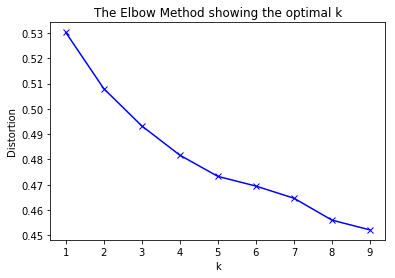

In [37]:
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

# k means determine k
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(melbourne_grouped_clustering)
    kmeanModel.fit(melbourne_grouped_clustering)
    distortions.append(sum(np.min(cdist(melbourne_grouped_clustering, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / melbourne_grouped_clustering.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

<h4>As shown above, the best value for k can be determined as 6.</h4>

In [64]:
kclusters = 6

neighborhoods_venues_sorted.drop(columns = 'Cluster Labels', inplace = True)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(melbourne_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 0, 3, 1, 0, 4, 3, 1, 3, 1])

In [68]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
melbourne_merged = data

In [69]:
neighborhoods_venues_sorted.head()

Cluster Labels        Suburb 1st Most Common Venue 2nd Most Common Venue  \
0               1    Abbotsford                   Pub                  Café   
1               0    Aberfeldie                  Café         Grocery Store   
2               3  Airport West    Italian Restaurant              Pharmacy   
3               1     Albanvale   Rental Car Location        Farmers Market   
4               0   Albert Park                  Café    Italian Restaurant   

  3rd Most Common Venue   4th Most Common Venue  5th Most Common Venue  \
0     Convenience Store  Thrift / Vintage Store            Pizza Place   
1           Zoo Exhibit       Food & Drink Shop      Fish & Chips Shop   
2         Grocery Store       Food & Drink Shop      Fish & Chips Shop   
3   Filipino Restaurant       Fish & Chips Shop            Fish Market   
4    Seafood Restaurant           Deli / Bodega  Australian Restaurant   

  6th Most Common Venue 7th Most Common Venue      8th Most Common Venue  \
0    Rock Climbing Spot           Coffee Shop                   Bus Line   
1           Fish Market           Flea Market                Flower Shop   
2           Fish Market           Flea Market                Flower Shop   
3           Flea Market           Flower Shop                       Food   
4           Snack Place        Breakfast Spot  Middle Eastern Restaurant   

  9th Most Common Venue 10th Most Common Venue  
0          Burger Joint                Gay Bar  
1                  Food             Food Court  
2                  Food             Food Court  
3     Food & Drink Shop             Food Court  
4             Bookstore       Greek Restaurant

In [70]:
melbourne_merged.head()

Suburb  Postcode   AvgPrice  Lattitude  Longtitude
0    Abbotsford   3067.00 1096603.90     -37.80      145.00
1  Airport West   3042.00  780529.42     -37.72      144.88
2   Albert Park   3206.00 1983664.71     -37.84      144.95
3    Alphington   3078.00 1441155.56     -37.78      145.03
4        Altona   3018.00  872917.93     -37.87      144.82

In [71]:
melbourne_merged = melbourne_merged.join(neighborhoods_venues_sorted.set_index('Suburb'), on='Suburb')
melbourne_merged

Suburb  Postcode   AvgPrice  Lattitude  Longtitude  \
0            Abbotsford   3067.00 1096603.90     -37.80      145.00   
1          Airport West   3042.00  780529.42     -37.72      144.88   
2           Albert Park   3206.00 1983664.71     -37.84      144.95   
3            Alphington   3078.00 1441155.56     -37.78      145.03   
4                Altona   3018.00  872917.93     -37.87      144.82   
5          Altona North   3025.00  828170.89     -37.83      144.85   
6              Armadale   3143.00 1590300.88     -37.86      145.02   
7            Ascot Vale   3032.00 1100420.45     -37.78      144.92   
8             Ashburton   3147.00 1743860.00     -37.87      145.08   
9               Ashwood   3147.00 1220920.45     -37.87      145.10   
10     Avondale Heights   3034.00  828106.19     -37.76      144.86   
11            Balaclava   3183.00  896184.21     -37.87      145.00   
12               Balwyn   3103.00 1990670.89     -37.81      145.08   
13         Balwyn North   3104.00 1856250.22     -37.79      145.09   
14            Bentleigh   3204.00 1349965.74     -37.92      145.04   
15       Bentleigh East   3165.00 1140139.91     -37.92      145.07   
16             Box Hill   3128.00 1382781.78     -37.82      145.13   
17            Braybrook   3019.00  721896.72     -37.79      144.85   
18             Brighton   3186.00 2086619.99     -37.91      145.00   
19        Brighton East   3187.00 1666556.22     -37.92      145.02   
20            Brunswick   3056.00 1026900.48     -37.77      144.96   
21       Brunswick West   3055.00  885080.27     -37.76      144.94   
22              Bulleen   3105.00 1176425.26     -37.77      145.09   
23              Burwood   3125.00 1308933.03     -37.85      145.11   
24           Camberwell   3124.00 1861382.32     -37.84      145.08   
25           Canterbury   3126.00 2279562.50     -37.82      145.08   
26        Carlton North   3054.00 1461892.31     -37.79      144.97   
27             Carnegie   3163.00  954113.22     -37.89      145.06   
28            Caulfield   3162.00  760423.08     -37.89      145.03   
29      Caulfield North   3161.00 1110892.86     -37.87      145.02   
30      Caulfield South   3162.00 1262471.43     -37.89      145.02   
31            Chadstone   3148.00  972235.29     -37.88      145.10   
32         Clifton Hill   3068.00 1336622.22     -37.79      145.00   
33               Coburg   3058.00  940443.94     -37.74      144.96   
34         Coburg North   3058.00  835820.22     -37.73      144.97   
35          Collingwood   3066.00  952712.33     -37.80      144.99   
36            Doncaster   3108.00 1303871.43     -37.78      145.12   
37            Eaglemont   3084.00 1774060.61     -37.76      145.06   
38          Elsternwick   3185.00 1415362.50     -37.89      145.01   
39               Elwood   3184.00 1031231.13     -37.88      144.99   
40             Essendon   3040.00 1164043.71     -37.75      144.91   
41       Essendon North   3041.00  910656.25     -37.74      144.90   
42            Fairfield   3078.00 1132422.41     -37.78      145.02   
43              Fitzroy   3065.00 1358296.30     -37.80      144.98   
44        Fitzroy North   3068.00 1361791.98     -37.78      144.98   
45           Flemington   3031.00  917632.91     -37.78      144.93   
46            Footscray   3011.00  747705.56     -37.80      144.89   
47            Glen Iris   3146.00 1692819.44     -37.86      145.07   
48              Glenroy   3046.00  695717.50     -37.70      144.92   
49            Gowanbrae   3043.00  728986.11     -37.70      144.90   
50             Hadfield   3046.00  712905.78     -37.71      144.94   
51              Hampton   3188.00 1728424.86     -37.94      145.01   
52         Hampton East   3188.00 1153488.89     -37.94      145.03   
53             Hawthorn   3122.00 1393527.20     -37.82      145.03   
54   Heidelberg Heights   3081.00  784218.50     -37.74      145.05   
55      Heidelberg West   3081.00  666244

In [72]:
melbourne_merged.dropna(inplace=True)

In [74]:
melbourne_merged['Cluster Labels'] = melbourne_merged['Cluster Labels'].astype(int)
melbourne_merged.dtypes

Suburb                     object
Postcode                  float64
AvgPrice                  float64
Lattitude                 float64
Longtitude                float64
Cluster Labels              int32
1st Most Common Venue      object
2nd Most Common Venue      object
3rd Most Common Venue      object
4th Most Common Venue      object
5th Most Common Venue      object
6th Most Common Venue      object
7th Most Common Venue      object
8th Most Common Venue      object
9th Most Common Venue      object
10th Most Common Venue     object
dtype: object

In [75]:
melbourne_merged.drop_duplicates(subset='Postcode',inplace=True)
melbourne_merged.shape

(197, 16)

In [76]:
melbourne_merged.reset_index(inplace=True)
melbourne_merged.drop(columns='index',inplace=True)

### Step 10: Displays how our cluster spread on the map of Melbourne city.

In [100]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(melbourne_merged['Lattitude'],melbourne_merged['Longtitude'], melbourne_merged['Suburb'], melbourne_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [77]:
melbourne_merged

Suburb  Postcode   AvgPrice  Lattitude  Longtitude  \
0            Abbotsford   3067.00 1096603.90     -37.80      145.00   
1          Airport West   3042.00  780529.42     -37.72      144.88   
2           Albert Park   3206.00 1983664.71     -37.84      144.95   
3            Alphington   3078.00 1441155.56     -37.78      145.03   
4                Altona   3018.00  872917.93     -37.87      144.82   
5          Altona North   3025.00  828170.89     -37.83      144.85   
6              Armadale   3143.00 1590300.88     -37.86      145.02   
7            Ascot Vale   3032.00 1100420.45     -37.78      144.92   
8             Ashburton   3147.00 1743860.00     -37.87      145.08   
9      Avondale Heights   3034.00  828106.19     -37.76      144.86   
10            Balaclava   3183.00  896184.21     -37.87      145.00   
11               Balwyn   3103.00 1990670.89     -37.81      145.08   
12         Balwyn North   3104.00 1856250.22     -37.79      145.09   
13            Bentleigh   3204.00 1349965.74     -37.92      145.04   
14       Bentleigh East   3165.00 1140139.91     -37.92      145.07   
15             Box Hill   3128.00 1382781.78     -37.82      145.13   
16            Braybrook   3019.00  721896.72     -37.79      144.85   
17             Brighton   3186.00 2086619.99     -37.91      145.00   
18        Brighton East   3187.00 1666556.22     -37.92      145.02   
19            Brunswick   3056.00 1026900.48     -37.77      144.96   
20       Brunswick West   3055.00  885080.27     -37.76      144.94   
21              Bulleen   3105.00 1176425.26     -37.77      145.09   
22              Burwood   3125.00 1308933.03     -37.85      145.11   
23           Camberwell   3124.00 1861382.32     -37.84      145.08   
24           Canterbury   3126.00 2279562.50     -37.82      145.08   
25        Carlton North   3054.00 1461892.31     -37.79      144.97   
26             Carnegie   3163.00  954113.22     -37.89      145.06   
27            Caulfield   3162.00  760423.08     -37.89      145.03   
28      Caulfield North   3161.00 1110892.86     -37.87      145.02   
29            Chadstone   3148.00  972235.29     -37.88      145.10   
30         Clifton Hill   3068.00 1336622.22     -37.79      145.00   
31               Coburg   3058.00  940443.94     -37.74      144.96   
32          Collingwood   3066.00  952712.33     -37.80      144.99   
33            Doncaster   3108.00 1303871.43     -37.78      145.12   
34            Eaglemont   3084.00 1774060.61     -37.76      145.06   
35          Elsternwick   3185.00 1415362.50     -37.89      145.01   
36               Elwood   3184.00 1031231.13     -37.88      144.99   
37             Essendon   3040.00 1164043.71     -37.75      144.91   
38       Essendon North   3041.00  910656.25     -37.74      144.90   
39              Fitzroy   3065.00 1358296.30     -37.80      144.98   
40           Flemington   3031.00  917632.91     -37.78      144.93   
41            Footscray   3011.00  747705.56     -37.80      144.89   
42            Glen Iris   3146.00 1692819.44     -37.86      145.07   
43              Glenroy   3046.00  695717.50     -37.70      144.92   
44            Gowanbrae   3043.00  728986.11     -37.70      144.90   
45              Hampton   3188.00 1728424.86     -37.94      145.01   
46             Hawthorn   3122.00 1393527.20     -37.82      145.03   
47   Heidelberg Heights   3081.00  784218.50     -37.74      145.05   
48           Hughesdale   3166.00 1113511.63     -37.90      145.08   
49              Ivanhoe   3079.00 1266603.05     -37.77      145.04   
50               Kealba   3021.00  602037.04     -37.73      144.82   
51          Keilor East   3033.00  837504.55     -37.74      144.87   
52                  Kew   3101.00 1868016.74     -37.80      145.04   
53             Kew East   3102.00 1744630.14     -37.79      145.05   
54              Kooyong   3144.00 2423333.33     -37.84      145.03   
55            Maidstone   3012.00  731805

### Step 11: Binning for Average Price
In this section, we will set average housing price with five bins. We will use matplotlib histogram to visualize each bin. Approximately, these five bins will be classified as follows:-
1.	Low Level : < 800,000
2.	Below Average : 800,000 – 1,200,000
3.	Average : 1,200,000 – 1,600,000
4.	Above Average : 1,600,000 – 2,000,000
5.	High Level : > 2,000,000

Text(0.5,1,'Price bins')

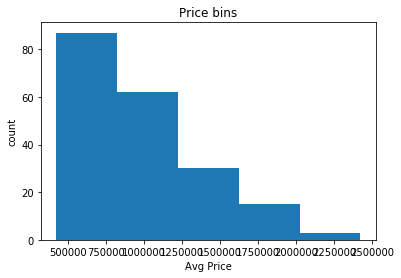

In [78]:
%matplotlib inline
import matplotlib as plt
from matplotlib import pyplot
plt.pyplot.hist(melbourne_merged["AvgPrice"],bins=5)

# set x/y labels and plot title
plt.pyplot.xlabel("Avg Price")
plt.pyplot.ylabel("count")
plt.pyplot.title("Price bins")

In [79]:
bins = np.linspace(min(melbourne_merged["AvgPrice"]), max(melbourne_merged["AvgPrice"]), 6)
bins

array([ 423000.        ,  823066.66666667, 1223133.33333333,
       1623200.        , 2023266.66666667, 2423333.33333333])

In [80]:
group_names = ['Low Level', 'Below Average', 'Average', 'Above Average', 'High Level']

In [81]:
melbourne_merged['Price-Categories'] = pd.cut(melbourne_merged['AvgPrice'], bins, labels=group_names, include_lowest=True )
melbourne_merged[['AvgPrice','Price-Categories']].head(10)

AvgPrice Price-Categories
0 1096603.90    Below Average
1  780529.42        Low Level
2 1983664.71    Above Average
3 1441155.56          Average
4  872917.93    Below Average
5  828170.89    Below Average
6 1590300.88          Average
7 1100420.45    Below Average
8 1743860.00    Above Average
9  828106.19    Below Average

### Step 12: Binning for Cluster Labels
For nearby venues, we will create four bins and label them as follows:-
1.	Café
2.	Mixed Social Venues
3.	Bars, Store and Restaurant
4.	Shops
5.	Parks and places

Text(0.5,1,'Cluster Labels')

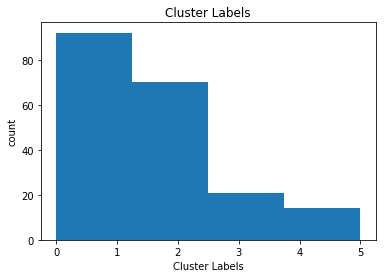

In [82]:
%matplotlib inline
import matplotlib as plt
from matplotlib import pyplot
plt.pyplot.hist(melbourne_merged["Cluster Labels"],bins=4)

# set x/y labels and plot title
plt.pyplot.xlabel("Cluster Labels")
plt.pyplot.ylabel("count")
plt.pyplot.title("Cluster Labels")

In [117]:
bins = np.linspace(min(melbourne_merged["Cluster Labels"]), max(melbourne_merged["Cluster Labels"]), 6)
bins

array([0., 1., 2., 3., 4., 5.])

In [118]:
group_names = ['Café','Mixed Social Venues','Bars, Store and Restaurant','Shops', 'Parks and places']

In [119]:
melbourne_merged['Cluster-Category'] = pd.cut(melbourne_merged['Cluster Labels'], bins, labels=group_names, include_lowest=True )
melbourne_merged[['Cluster Labels','Cluster-Category']]

Cluster Labels            Cluster-Category
0                 1                        Café
1                 3  Bars, Store and Restaurant
2                 0                        Café
3                 3  Bars, Store and Restaurant
4                 1                        Café
5                 3  Bars, Store and Restaurant
6                 0                        Café
7                 0                        Café
8                 3  Bars, Store and Restaurant
9                 2         Mixed Social Venues
10                3  Bars, Store and Restaurant
11                0                        Café
12                4                       Shops
13                2         Mixed Social Venues
14                2         Mixed Social Venues
15                1                        Café
16                4                       Shops
17                0                        Café
18                1                        Café
19                1                        Café
20                1                        Café
21                3  Bars, Store and Restaurant
22                5            Parks and places
23                4                       Shops
24                1                        Café
25                0                        Café
26                2         Mixed Social Venues
27                2         Mixed Social Venues
28                3  Bars, Store and Restaurant
29                2         Mixed Social Venues
30                0                        Café
31                0                        Café
32                1                        Café
33                1                        Café
34                2         Mixed Social Venues
35                1                        Café
36                0                        Café
37                1                        Café
38                2         Mixed Social Venues
39                3  Bars, Store and Restaurant
40                2         Mixed Social Venues
41                2         Mixed Social Venues
42                0                        Café
43                2         Mixed Social Venues
44                2         Mixed Social Venues
45                0                        Café
46                2         Mixed Social Venues
47                0                        Café
48                0                        Café
49                2         Mixed Social Venues
50                4                       Shops
51                1                        Café
52                2         Mixed Social Venues
53                0                        Café
54                2         Mixed Social Venues
55                0                        Café
56                2         Mixed Social Venues
57                1                        Café
58                2         Mixed Social Venues
59                0                        Café
60                2         Mixed Social Venues
61                0                        Café
62                0                        Café
63                1                        Café
64                2         Mixed Social Venues
65                1                        Café
66                0                        Café
67                1                        Café
68                2         Mixed Social Venues
69                1                        Café
70                0                        Café
71                0                        Café
72                0                        Café
73                2         Mixed Social Venues
74                2         Mixed Social Venues
75                2         Mixed Social Venues
76                1                        Café
77                1                        Café
78                0                        Café
79                2         Mixed Social Venues
80                2         Mixed Social Venues
81                0                        Café
82                2  

### Step 13: Final Data Set

In [102]:
melbourne_merged.drop(columns=['6th Most Common Venue','7th Most Common Venue','8th Most Common Venue','9th Most Common Venue','10th Most Common Venue'],inplace=True)
melbourne_merged.head()

Suburb  Postcode   AvgPrice  Lattitude  Longtitude  Cluster Labels  \
0    Abbotsford   3067.00 1096603.90     -37.80      145.00               1   
1  Airport West   3042.00  780529.42     -37.72      144.88               3   
2   Albert Park   3206.00 1983664.71     -37.84      144.95               0   
3    Alphington   3078.00 1441155.56     -37.78      145.03               3   
4        Altona   3018.00  872917.93     -37.87      144.82               1   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0                   Pub                  Café     Convenience Store   
1    Italian Restaurant              Pharmacy         Grocery Store   
2                  Café    Italian Restaurant    Seafood Restaurant   
3     Convenience Store         Train Station  Gym / Fitness Center   
4           Pizza Place           Zoo Exhibit     Food & Drink Shop   

    4th Most Common Venue  5th Most Common Venue Price-Categories  \
0  Thrift / Vintage Store            Pizza Place    Below Average   
1       Food & Drink Shop      Fish & Chips Shop        Low Level   
2           Deli / Bodega  Australian Restaurant    Above Average   
3         Thai Restaurant                   Café          Average   
4     Filipino Restaurant      Fish & Chips Shop    Below Average   

             Cluster-Category  
0                        Café  
1  Bars, Store and Restaurant  
2                        Café  
3  Bars, Store and Restaurant  
4                        Café

### Step 14: Melbourne house pricing cluster by nearby venues

In [87]:
# add markers to the map
mel_map = folium.Map(location = [latitude, longitude], zoom_start = 11)
markers_colors = []
for lat, lon, poi, cluster in zip(melbourne_merged['Lattitude'],melbourne_merged['Longtitude'], melbourne_merged['Suburb'], melbourne_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(mel_map)
       
# display map
mel_map

In [167]:
lbl0_df = melbourne_merged[melbourne_merged['Cluster Labels']==0]
lbl1_df = melbourne_merged[melbourne_merged['Cluster Labels']==1]
cafe_df = pd.concat([lbl0_df, lbl1_df])
mixed_df = melbourne_merged[melbourne_merged['Cluster Labels']==2]
restau_df = melbourne_merged[melbourne_merged['Cluster Labels']==3]
shops_df = melbourne_merged[melbourne_merged['Cluster Labels']==4]
parks_df = melbourne_merged[melbourne_merged['Cluster Labels']==5]

# 4. Result & Findings

### Step 15: Create bar chart from result data
We will examine our result data set with visualization. First of all, let’s explore the distribution of nearby venues.

In [153]:
x = ['Café', 'Mixed Social Venues', 'Bars/Store/Restaurant', 'Shops', 'Parks/Places']
nearby_count_values =  [cafe_df.shape[0], mixed_df.shape[0], restau_df.shape[0], shops_df.shape[0], parks_df.shape[0]]
nearby_count_df = pd.DataFrame(nearby_count_values, index =x, 
                                              columns =['Total Nearby Venues']) 
nearby_count_df 

Total Nearby Venues
Café                                    92
Mixed Social Venues                     70
Bars/Store/Restaurant                   21
Shops                                   11
Parks/Places                             3

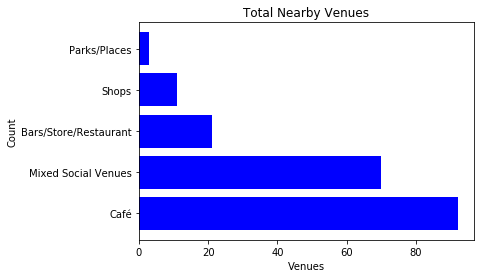

In [154]:
import matplotlib.pyplot as plt

x_pos = [i for i, _ in enumerate(x)]

plt.barh(x_pos, nearby_count_values, color='blue')
plt.ylabel("Count")
plt.xlabel("Venues")
plt.title("Total Nearby Venues")

plt.yticks(x_pos, x)

plt.show()

In [155]:
x = ['Low Level', 'Below Average', 'Average', 'Above Average', 'High Level']
p1 = melbourne_merged[melbourne_merged['Price-Categories']=='Low Level'].shape[0]
p2 = melbourne_merged[melbourne_merged['Price-Categories']=='Below Average'].shape[0]
p3 = melbourne_merged[melbourne_merged['Price-Categories']=='Average'].shape[0]
p4 = melbourne_merged[melbourne_merged['Price-Categories']=='Above Average'].shape[0]
p5 = melbourne_merged[melbourne_merged['Price-Categories']=='High Level'].shape[0]
price_count_values = [p1, p2, p3, p4, p5]
price_count_df = pd.DataFrame(price_count_values, index =x, 
                                              columns =['Total in Price Category']) 
price_count_df 

Total in Price Category
Low Level                           87
Below Average                       62
Average                             30
Above Average                       15
High Level                           3

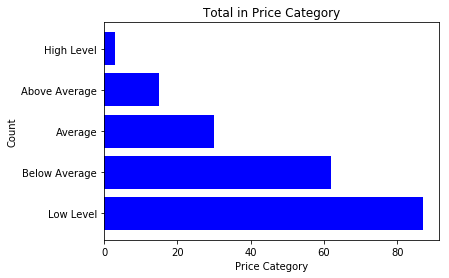

In [156]:
import matplotlib.pyplot as plt

x_pos = [i for i, _ in enumerate(x)]

plt.barh(x_pos, price_count_values, color='blue')
plt.ylabel("Count")
plt.xlabel("Price Category")
plt.title("Total in Price Category")

plt.yticks(x_pos, x)

plt.show()

In [157]:
def get_averages(data):
    l1_df = data[data['Price-Categories']=='Low Level']
    v1 = l1_df['AvgPrice'].describe().loc['mean']
    l2_df = data[data['Price-Categories']=='Below Average']
    v2 = l2_df['AvgPrice'].describe().loc['mean']
    a1_df = data[data['Price-Categories']=='Average']
    v3 = a1_df['AvgPrice'].describe().loc['mean']
    a2_df = data[data['Price-Categories']=='Above Average']
    v4 = a2_df['AvgPrice'].describe().loc['mean']
    aa_df = data[data['Price-Categories']=='High Level']
    v5 = aa_df['AvgPrice'].describe().loc['mean']
    return [v1, v2, v3, v4, v5]

In [158]:
list1 = get_averages(cafe_df)
list2 = get_averages(mixed_df)
list3 = get_averages(restau_df)
list4 = get_averages(shops_df)
list5 = get_averages(parks_df)

df = pd.DataFrame(list(zip(list1, list2, list3, list4, list5)), index =['Low Level', 'Below Average', 'Average', 'Above Average','High Level'], 
                                              columns =['Café', 'Mixed Social Venues', 'Bars/Store/Restaurant','Shops', 'Parks/Places']) 
df

Café  Mixed Social Venues  Bars/Store/Restaurant  \
Low Level      650443.98            676052.28              662906.31   
Below Average 1017134.57            962482.67              984402.94   
Average       1393744.33           1390169.05             1369113.25   
Above Average 1801127.71           1765751.65             1747225.83   
High Level    2183091.25           2423333.33                    nan   

                   Shops  Parks/Places  
Low Level      640540.97     665000.00  
Below Average  885100.00    1078272.75  
Average              nan    1308933.03  
Above Average 1858816.27           nan  
High Level           nan           nan

#### With above data table, we can easily suggest how much budget is needed to buy a house in Melbourne that is near to a Café or Bars or Shops. The cheapest housing prices are near either Café or Shops whereby most expensive housing are near Parks or Mixed Social Venues. 

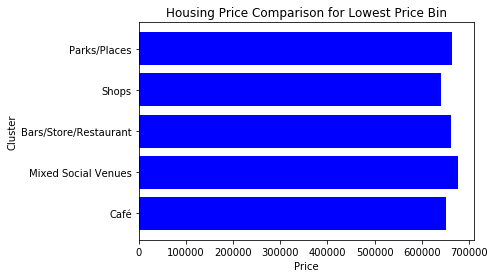

In [145]:
import matplotlib.pyplot as plt

x = ['Café', 'Mixed Social Venues', 'Bars/Store/Restaurant','Shops', 'Parks/Places']
values =  [list1[0], list2[0], list3[0], list4[0], list5[0]]

x_pos = [i for i, _ in enumerate(x)]

plt.barh(x_pos, values, color='blue')
plt.ylabel("Cluster")
plt.xlabel("Price")
plt.title("Housing Price Comparison for Lowest Price Bin")

plt.yticks(x_pos, x)

plt.show()

#### Above histogram displayed the first row of our data frame to compare which venues has the lowest average housing price inside “Lowest Price” bin. The answer is to look for a house near “Shops” venue. We can apply similar visualization to answer different questions regarding Melbourne housing price.

# 5. Recommendation
This notebook can be extended to further data science project such as predicting housing price in a Suburb where the house is located near a park, etc.

# 6. Conclusion
With the help of machine learning, namely unsupervised machine learning algorithm K-mean, we can cluster venues data and analyse the average housing price for each venue. For a real estate agent, he or she can make use of this data to suggest a buyer on how much money they may need to spend to buy a house. For individual family, this data allows further financial planning to fulfil Australians’ dream. And even for property builders, they will know which spot is profitable to build a new lodging. 

#### References - https://www.kaggle.com/anthonypino/melbourne-housing-market#Melbourne_housing_FULL.csv